In [30]:
import pandas as pd
import glob 
import numpy as np
import os
import trajectory_planning_helpers as tph
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from f1tenth_sim.utils.MapData import MapData

save_path = '../Data/BenchmarkArticle/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [24]:

summary_df = pd.read_csv("../Logs/Summary.csv")

planners = ['GlobalPlanPP', "FollowTheGap", "EndToEnd"]
test_ids = ["mu70", "Std", "TD3v6"]
neat_planner_names = ["Pure pursuit", "Follow the gap", "End-to-end"]
n_planners = len(planners)
planner_colors = ["#F97F51", "#3B3B98", "#55E6C1"]

map_list = ["aut", "esp", "gbr", "mco"]
n_laps = 5



In [19]:

lap_dfs = []
for i, planner_name in enumerate(planners):
    for m, map_name in enumerate(map_list):
        for lap_n in range(n_laps):
            data = np.load(f"../Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{map_name}_{lap_n}.npy")[1:, :] #remove first repeated entry
            df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
            df.steer_a = df.steer_a * 180 / np.pi
            df.yaw = df.yaw * 180 / np.pi
            df.slip = df.slip.abs() * 180 / np.pi

            el_lengths = np.linalg.norm(np.diff(data[:, :2], axis=0), axis=1)
            psi, kappa = tph.calc_head_curv_num.calc_head_curv_num(data[:, :2], el_lengths, False)
            df["curvature"] = np.abs(kappa) * 180 / np.pi
            df["d_steer"] = df.steer_a.diff().abs()
            df["lap_n"] = lap_n
            df["planner"] = planner_name
            df["map_name"] = map_name

            data = np.load(f"../Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{map_name}_{lap_n}.npy")[1:, :] #remove first repeated entry
            df["ct_error"] = np.abs(data[:, 1])
            df["speed_error"] = np.abs(data[:, 4])
            lap_dfs.append(df)

lap_df = pd.concat(lap_dfs)
lap_df.dropna(inplace=True)
print(lap_df.head())


          x         y  steer     speed       yaw  yaw_rate      slip  \
1  0.003994  0.000000  0.000  0.323340  0.000000  0.000000  0.000000   
2  0.022634  0.000000  0.000  0.703740  0.000000  0.000000  0.000000   
3  0.056489  0.000000  0.000  1.084140  0.000000  0.000000  0.000000   
4  0.105236  0.000000  0.064  1.428889  0.000000  0.065865  0.222035   
5  0.166807  0.001083  0.192  1.712596  0.510843  0.543318  2.103703   

     steer_a   speed_a  progress  curvature    d_steer  lap_n       planner  \
1   0.000000  4.000000       0.0   0.000000   0.000000      0  GlobalPlanPP   
2   0.000000  4.000000       0.0   0.000000   0.000000      0  GlobalPlanPP   
3  22.918312  3.031224       0.0   6.809432  22.918312      0  GlobalPlanPP   
4  22.918312  3.031224       0.0  23.812286   0.000000      0  GlobalPlanPP   
5  22.918312  3.031224       0.0  43.247516   0.000000      0  GlobalPlanPP   

  map_name  ct_error  speed_error  
1      aut  0.000000     0.000000  
2      aut  0.000000

In [50]:

results_df = summary_df.loc[summary_df.Vehicle.isin(planners)]
results_df = results_df.loc[results_df.TestID.isin(test_ids)]

times_df = results_df.pivot(index="Vehicle", columns="MapName", values="AvgTime")
times_df.columns = times_df.columns.str.upper()
times_df.rename(index=dict(zip(planners, neat_planner_names)), inplace=True)
print(times_df)

times_df.to_latex(f"{save_path}benchmark_laptimes.tex", float_format="%.2f")


MapName            AUT     ESP     GBR     MCO
Vehicle                                       
End-to-end      21.096  46.464  41.024  36.560
Follow the gap  19.030  45.744  39.320  35.016
Pure pursuit    18.664  39.216  33.920  30.552


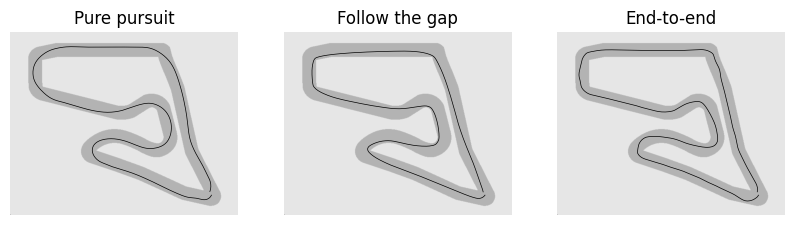

In [23]:
plot_map = "aut"
map_data = MapData(plot_map)

fig, axs = plt.subplots(1, n_planners, figsize=(10, 2.5), sharey=True)
for i in range(n_planners):
    plt.sca(axs[i])
    map_data.plot_map_img()

    df = lap_df[lap_df["planner"] == planners[i]]
    df = df[df["map_name"] == plot_map]
    df = df[df['lap_n'] == 2]

    xs, ys = map_data.xy2rc(df.x, df.y)
    plt.plot(xs, ys, color="black", linewidth=0.5)
    
    plt.axis('off')
    plt.title(neat_planner_names[i])

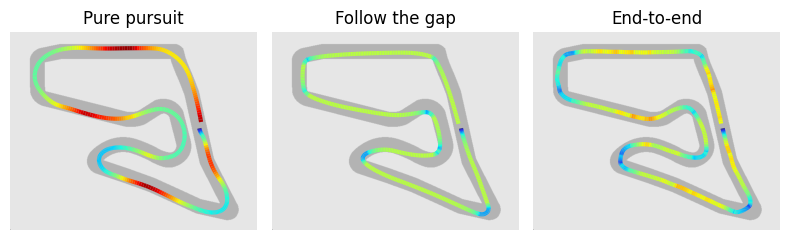

In [36]:
plot_map = "aut"
map_data = MapData(plot_map)

fig, axs = plt.subplots(1, n_planners, figsize=(8, 2.5), sharey=True)
for i in range(n_planners):
    plt.sca(axs[i])
    map_data.plot_map_img()

    df = lap_df[lap_df["planner"] == planners[i]]
    df = df[df["map_name"] == plot_map]
    df = df[df['lap_n'] == 4]

    xs, ys = map_data.xy2rc(df.x, df.y)
    pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
    norm = plt.Normalize(1, 8)
    lc = LineCollection(segments, cmap='jet', norm=norm)
    lc.set_array(df.speed.values)
    lc.set_linewidth(3)
    line = plt.gca().add_collection(lc)
    
    plt.axis('off')
    plt.title(neat_planner_names[i])
plt.tight_layout()

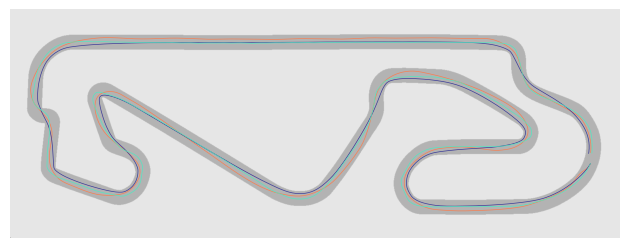

In [37]:
plot_map = "esp"
map_data = MapData(plot_map)

fig = plt.figure()
map_data.plot_map_img()
for i in range(n_planners):

    df = lap_df[lap_df["planner"] == planners[i]]
    df = df[df["map_name"] == plot_map]
    df = df[df['lap_n'] == 3]

    xs, ys = map_data.xy2rc(df.x, df.y)
    plt.plot(xs, ys, linewidth=0.5, color=planner_colors[i])
    
    plt.axis('off')
plt.tight_layout()


In [42]:

lap_df_drop = lap_df[["slip", "curvature", "steer_a", "d_steer", "speed_error", "ct_error", "planner", "lap_n"]].copy()
lap_df_drop.steer_a = lap_df_drop.steer_a.abs()
lap_avg_view = lap_df_drop.groupby(["planner", "lap_n"])
lap_avg = lap_avg_view.mean()
lap_std = lap_avg_view.std()

mean_df = lap_avg.groupby("planner").mean()
mean_df.columns = ["Slip", "Curvature", "Steering angle", "Steer rate", "Speed error", "CT error"]
mean_df.index = neat_planner_names
print(mean_df)

mean_df.to_latex(f"{save_path}benchmark_quality_measures.tex", float_format="%.2f")



                    Slip  Curvature  Steering angle  Steer rate  Speed error  \
Pure pursuit    1.967614  10.993725        5.561037    2.262498     3.226769   
Follow the gap  1.385812   8.000083        2.891941    0.603526     3.192376   
End-to-end      2.315225   9.883363        4.042823    0.651383     3.173214   

                 CT error  
Pure pursuit    13.374047  
Follow the gap  13.180765  
End-to-end      13.725627  


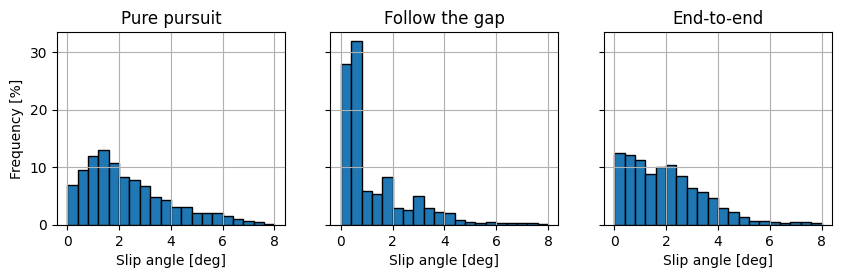

In [49]:
fig, axs = plt.subplots(1, n_planners, figsize=(10, 2.5), sharey=True)
for i in range(n_planners):
    plt.sca(axs[i])
    df = lap_df[lap_df["planner"] == planners[i]]
    df = df[df['lap_n'] < 5]
    df = df.slip
    
    hist, edges = np.histogram(df, bins=20, range=(0, 8))
    freq = hist / float(hist.sum()) * 100
    width = np.diff(edges) # edges is bins
    plt.bar(edges[:-1], freq, width=width, align="edge", ec="k")
    plt.xlabel("Slip angle [deg]")
    plt.title(neat_planner_names[i])
    plt.grid(True)

axs[0].set_ylabel("Frequency [%]")
plt.savefig(f"{save_path}benchmark_slip.pdf", bbox_inches="tight")

Text(0, 0.5, 'Frequency [%]')

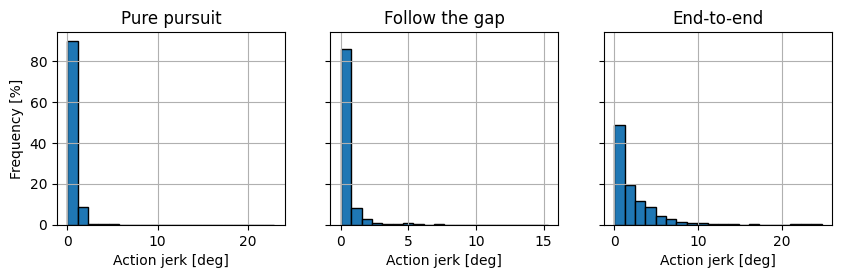

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(10, 2.5), sharey=True)
for i in range(3):
    plt.sca(axs[i])
    df = lap_df[lap_df["planner"] == planners[i]]
    df = df[df['lap_n'] < 5]
    df = df.d_steer
    hist, edges = np.histogram(a_dfs[i], bins=20)
    freq = hist / float(hist.sum()) * 100
    width = np.diff(edges) # edges is bins
    plt.bar(edges[:-1], freq, width=width, align="edge", ec="k")
    plt.xlabel("Action jerk [deg]")
    plt.title(neat_planner_names[i])
    plt.grid(True)

axs[0].set_ylabel("Frequency [%]")

(0.0, 10.0)

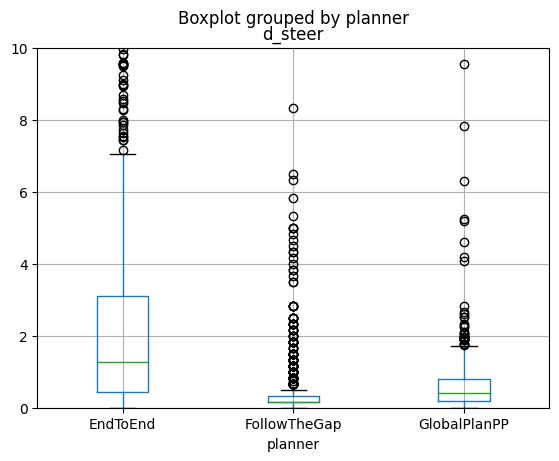

In [62]:

# df = lap_df[lap_df["planner"] == planners[i]]
lap_df = lap_df[lap_df['lap_n'] < 1]
# df = df.d_steer

lap_df.boxplot(by="planner", column="d_steer")
plt.ylim(0, 10)

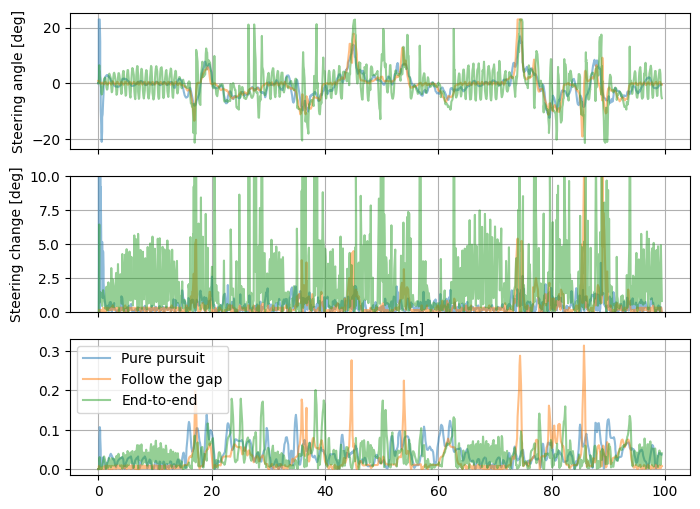

In [7]:
map_name = "esp"
lap_n = 1
from matplotlib.ticker import PercentFormatter

dfs = []
for i in range(3):
    data = np.load(f"../Logs/{planners[i]}/RawData_{test_ids[i]}/SimLog_{map_name}_{lap_n}.npy")[1:, :] #remove first repeated entry
    df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
    df.steer_a = df.steer_a * 180 / np.pi
    df.progress = df.progress * 100
    df = df[["steer_a", "progress", "slip"]]
    df["d_steer"] = df.steer_a.diff().abs()
    dfs.append(df)

# df = pd.concat(dfs, axis=1)
# df.columns = neat_planner_names

# df_d = df.diff().abs()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
ax1.set_ylabel("Steering angle [deg]")
ax2.set_xlabel("Progress [m]")
ax2.set_ylabel("Steering change [deg]")

for i in range(3):
    df = dfs[i]
    ax1.plot(df["progress"], df["steer_a"], label=neat_planner_names[i], alpha=0.5)

    ax2.plot(df["progress"], df["d_steer"], label=neat_planner_names[i], alpha=0.5)

    ax3.plot(df["progress"], df["slip"].abs(), label=neat_planner_names[i], alpha=0.5)

ax1.grid(True)
ax2.grid(True)
ax2.set_ylim(0, 10)
ax3.grid(True)

plt.legend()

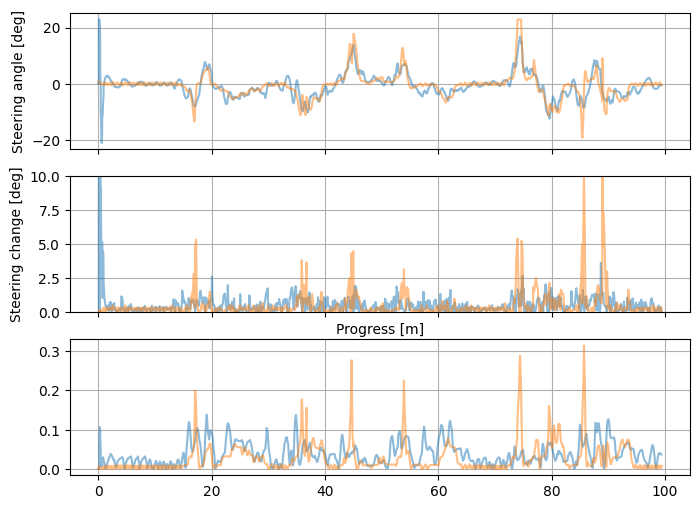

In [18]:
map_name = "esp"
lap_n = 1
from matplotlib.ticker import PercentFormatter

planners = ['GlobalPlanPP', "FollowTheGap", "EndToEnd"]
test_ids = ["mu70", "Std", "TestTD3"]

dfs = []
for i in range(3):
    data = np.load(f"../Logs/{planners[i]}/RawData_{test_ids[i]}/SimLog_{map_name}_{lap_n}.npy")[1:, :] #remove first repeated entry
    df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
    df.steer_a = df.steer_a * 180 / np.pi
    df.progress = df.progress * 100
    df = df[["steer_a", "progress", "slip"]]
    df["d_steer"] = df.steer_a.diff().abs()
    dfs.append(df)

# df = pd.concat(dfs, axis=1)
# df.columns = neat_planner_names

# df_d = df.diff().abs()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
ax1.set_ylabel("Steering angle [deg]")
ax2.set_xlabel("Progress [m]")
ax2.set_ylabel("Steering change [deg]")

for i in range(2):
    df = dfs[i]
    ax1.plot(df["progress"], df["steer_a"], label=neat_planner_names[i], alpha=0.5)

    ax2.plot(df["progress"], df["d_steer"], label=neat_planner_names[i], alpha=0.5)

    ax3.plot(df["progress"], df["slip"].abs(), label=neat_planner_names[i], alpha=0.5)

ax1.grid(True)
ax2.grid(True)
ax2.set_ylim(0, 10)
ax3.grid(True)